# LoCPb - Final Project

# Variational Monte Carlo methods for many-body quantum systems 
## Transverse Field Ising Model's ground state estimation 

### Students
* Alessandro Marcomini (2024286)
* Giulia Campesan (2027592)
* Tommaso Faorlin (2021857)

###  References
1. [G. Carleo, M. Troyer,   'Solving the quantum many-body problem with artificial neural networks' ](https://science.sciencemag.org/content/355/6325/602)
2. [P. Mehta et al.  'A high-bias, low-variance introduction to Machine Learning for physicists'](https://arxiv.org/abs/1803.08823)
3. [C. Bauer, K. Hyatt   'Quantum Ising Phase Transition'](https://juliaphysics.github.io/PhysicsTutorials.jl/tutorials/general/quantum_ising/quantum_ising.html)
4. [M. Dalmonte, S. Montangero  'Lattice gauge theory simulations in the quantum information era'](https://www.tandfonline.com/doi/full/10.1080/00107514.2016.1151199)
5. [S. Sorella et al., 'Weak binding be- tween two aromatic rings: Feeling the van der Waals at- traction by quantum Monte Carlo method'](https://arxiv.org/abs/cond-mat/0702349)
6. [I. Gonzalez, 'DMRG algorithm for the Ising model in a transverse field'](https://dmrg101-tutorial.readthedocs.io/en/latest/tfim.html#dmrg-algorithm-for-the-ising-model-in-a-transverse-field)
7. [P. Calabrese et al.,'Quantum Quench in the Transverse Field Ising chain I: Time evolution of order parameter correlators'](https://arxiv.org/pdf/1204.3911.pdf)


<a id="reference_cell"></a>

## Project goal

The goal of this project is the implementation of a neural network in the form of a Restricted Boltzmann Machine (RBM) to encode the quantum wavefunction $\psi$ of a fermionic spin lattice. In particular, we investigate the potential of this method by checking its ability to correctly generate the probability distribution of the many-body quantum states and exploit it in a Monte Carlo fashion to stochastically evaluate the ground state of a one-dimentional model.

#### The Restricted Boltmann Machine

A Restricted Boltzmann Machine (RBM) is an **energy-based** model with both visible and hidden units where the visible and hidden units interact with each other but do not interact among themselves. This last brief description is where they take the name from. In fact, unrestricted Boltzmann Machines allow to have connection among the hidden units. The energy function of an RBM takes the general functional form:

$$E(\pmb{v},\pmb{h})=-\sum_i a_i(v_i)-\sum_\mu b_\mu(h_\mu)-\sum_{i,\mu}W_{i\mu}v_ih_\mu$$

where $a_i(\cdot)$ and $b_\mu(\cdot)$ are functions that we are free to choose. The most common choice, when $v_i$ are binary variables (this will be our case) is: 

$$a_i(v_i)=a_iv_i\quad\quad b_\mu(h_\mu)=a_\mu h_\mu$$

<img src="RBM.png" alt="drawing" width="800"/>

The architecture we are dealing with is composed of one visible layer of $N$ units, taking as input our spin variables, $\mathcal{S}=\{\sigma_i\}_{i=1,...,N}$ and one hidden Bernoulli layer of $M$ latent spin 1/2 variables 
$H=\{h_j\}_{j=1,...,M}$. The number of hidden nodes is set proportional to the number of visible units $M=\alpha N, \alpha \in \mathbb{N}$, in which the proportionality constant $\alpha$ is called density ad we initially set it to 1, due to the computational limits of our hardware. We restrict our Boltzmann Machine to display interactions only between two nodes laying in different layers and not among visible or hidden units themselves [2](#reference_cell).
Then, given the values of the visible units $\mathcal{S}=\{\sigma\}_i$ and the weights of the network $W=\{a_i, b_j, W_{ij}\}$ the wave-function is fully determined and its variational form is given by
$$\psi(\mathcal{S}; W)=\sum_{\{h_j\}}\exp\bigl(\sum_i a_i \sigma^z_i+\sum_j b_j h_j +\sum_{ij} W_{ji}h_j\sigma^z_i\bigr) $$
in which we are summing over all the possible $2^M$ configurations of the $M$ hidden spin variables and the absence of intra-layer interactions allows to recast the previous expression as
$$\psi(\mathcal{S}; W)=\exp\bigl(\sum_i a_i \sigma^z_i \prod_{j=1}^M 2\cosh\bigl[b_j+\sum_i W_{ji} \sigma^z_i\bigr]\bigr)$$
Since for large systems the exact wave function is often unknown, we can not exploit any supervised learning technique for inferring $\psi_G$ [1](#reference_cell).  
We rely on a stochastic optimization approach for the RBM training based on the following iterative procedure, that will start with the proposal of a random state for our system.
At the  $k_{th}$ iteration:
* The minimization of the expectation value of the energy 

$$E=\frac{\langle  \psi_{k-1} | \mathcal{H} | \psi_{k-1}\rangle}{\|\psi_{k-1}\|^2}$$ 

with respect to the network weights $W$ is performed, retrieving a new set of weights $W_k$,
* a new state $\mathcal{S}_k$ is sampled from $|\psi(\mathcal{S}; W_k)|^2$, by making use of a Monte Carlo sampling.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [10]:
#initialization functions:
def NewSpinSequence(N_vis, code, zero_mag):
    '''
    -> Generation of a new spin sequence
    IN
    N_vis = number of nodes in the visible layer
    code  = particle encoding (e.g. bits [0,1], spin1 [-1,+1], spin1/2 [-1/2,1/2])
    zero_mag = Bool stating if the total magnetization must be zero
    
    OUT
    proposed state (n_visible,)
    '''
    state = np.random.choice(code, N_vis, p=[0.5, 0.5])
    if zero_mag: Demagnetize(state)
    return state

def Demagnetize(state, verbose = False):
    '''
    -> Transform an incoming sequence to a sequence with null net magnetization 
    
    IN 
    state = current sequence of spins
    verbose = some useful printouts
    
    OUT 
    void
    '''
    
    total_mag_init = sum(state)
    total_mag = total_mag_init
    
    if total_mag > 0:
        while total_mag != 0:
            state[int(np.random.choice(np.where(state > 0)[0], 1))] *= -1
            total_mag = sum(state)
            
    elif total_mag < 0:
        while total_mag != 0:
            state[int(np.random.choice(np.where(state < -0)[0], 1))] *= -1
            total_mag = sum(state)
            
    if verbose:
        print('Initial magnetization of the state:', total_mag_init)
        print('Final magnetization of the state:',   total_mag)

def InitializeRBM(N_vis, N_hid, Init_weights):
    '''
    -> RBM initialization
    IN 
    N_vis = number of nodes in the visible layer
    N_hid  = number of nodes in the hidden layer
    Init_weights = multiplicative constant to multiply weights
    
    OUT
    A = initial values for the visible layer's nodes: numpy array (N, 1)
    B = initial values for the hidden layer's nodes               (M, 1)
    W = initial values for the fully connected layer              (N, M)
    '''
    
    N = N_vis
    M = N_hid
    
    A = (Init_weights * (np.random.rand(N, 1)-0.5)).astype(dtype=complex)
    B = (Init_weights * (np.random.rand(M, 1)-0.5)).astype(dtype=complex)
    W = (Init_weights * (np.random.rand(N, M)-0.5)).astype(dtype=complex)
    
    return A, B, W

def Theta(B, W, state):
    '''
    -> Computation of the thetas

    IN
    B, W = parameters of the current RBM, shapes (M,1) and (N,M)
    state  = current sequence of spins, shape (N,1)

    OUT
    a series of numbers representing thetas (N,1)
    '''
    s = np.array(state, dtype=float).reshape(-1, 1)
    th = B+np.dot(W.T, s)
    return th

def UpdateLookupThetas(lookup_ths, W, prev_state, new_state):
    '''
    -> Updates the lookup table for theta
    
    IN
    lookup_ths       = current lookup table
    W                = W weights of the RBM
    prev_state       = state before update
    new_state        = state after update
    
    OUT
    void 
    '''
    delta_s = (new_state - prev_state).reshape(len(prev_state),1)
    lookup_ths += np.dot(W.T, delta_s)

## The 1D Trasverse Field Ising (TFI) model
First of all, we define the model used to test the validity of our implementation: the TFI Ising model.
The system is made of $N$ quantum spins $\{\pmb \sigma_i\}_{i=1,..,N}$, where $\pmb{\sigma_i} = \sigma_i \hat{z}$ and $\sigma_i \in \left\{-\tfrac{1}{2},\tfrac{1}{2}\right\}$, occupying the site of a 1D lattice, forming a chain. In the region occupied by the chain, a transverse uniform magnetic field $\pmb h=h\hat x$ is present, whose interaction with the spins leads from a trivial classical Ising model with nearest neighbours interaction to a quantum model represented by the following Hamiltonian:
$$\mathcal{H}=-\frac{J}{2}\sum_{<ij>}\sigma^z_i \otimes \sigma^z_j-h \sum_i \sigma^x_i$$
in which $\sigma^z=\begin{pmatrix}
1 & 0\\
0 & -1 
\end{pmatrix}, \sigma^x=\begin{pmatrix}
0 & 1\\
1 & 0 
\end{pmatrix}$ are the two Pauli matrices representing the $Z$ and $X$ components of the single particle spin variable and $J$ is the coupling constant between two adjacent spin, that will be set to $J=2$ from now on.


We sample our states as sequences of spin variables according to their sign, where the $i_{th}$ entry represents the particle state $|s_i>$. Hence, the encoding is the following:
* the '1' value encodes the |$\uparrow$> eigenvector of $\sigma_z: \sigma_z|s_i>=\sigma_z|\uparrow>=+1|\uparrow>$ and $\sigma_x|\uparrow>=|\downarrow>$
* the '-1' value encodes the |$\downarrow$> eigenvector of $\sigma_z: \sigma_z|s_i>=\sigma_z|\downarrow>=-1|\downarrow>$ and $\sigma_x|\downarrow>=|\uparrow>$

Then when our $N$-spins state $\mathcal{S}$ will be given as $\mathcal{S}=|s_1>\otimes\dots\otimes |s_j> \otimes\dots\otimes |s_n>$ and the notation used in the Hamiltonian is then

$$\sigma^x_i:=\mathbb{1}_1\otimes\dots\otimes\mathbb{1}_{i-1}\otimes\sigma^x_i\otimes \mathbb{1}_{i+1}\otimes\dots\otimes\mathbb{1}_n\quad\quad\sigma^z_i\sigma^z_j:=\mathbb{1}_1\otimes\dots\otimes\mathbb{1}_{i-1}\otimes\sigma^z_i\otimes\mathbb{1}_{i+1}\otimes\dots\otimes\mathbb{1}_{j-1}\otimes\sigma^z_j\otimes\mathbb{1}_{j+1}\otimes\dots\otimes\mathbb{1}_n$$

where $\mathbb{1}$ is the 2x2 identity matrix.

#### Matrix elements
As explained below, in order to give an estimate of the local energy, we need to compute the matrix elements for all the transitions from a particular state, knowing $\mathcal{H}$. So, given a spin state $\mathcal{S}$, the non-null matrix elements will account for all the possible transitions from it to $\mathcal{S}'$ obtained with the random flipping of one single spin in $\mathcal{S}$. 

Let's start from the calculation of the expectation value of $\mathcal{H}$ in a state $\mathcal{S}$, so the transition rate between a state and itself (no flips) $\langle \mathcal{S} | \mathcal{H} | \mathcal{S}\rangle$. For the interaction with the transverse field term, it is straightforward to see that the action of the $\sigma_x$ Pauli matrix acts as a 'quantum NOT gate' (i.e. it maps a state to its orthogonal), producing in the end a null transition rate. Let's fix $s_i = +1$ ($|s_i>=(1,0)^T$) and do a simple calculation:

$$\langle s_i|\sigma_i^x|s_i\rangle=\langle+1|\sigma_i^x|+1\rangle=\langle+1|-1\rangle=0$$

On the other hand, the interaction part is contributing to the final result, and we provide here an example for a single nearest neighbour interaction. Let's for example imagine that $|s_i>=(1,0)^T$ and $|s_j>=(1,0)^T$. 
The calculation goes as follows:

$$\langle s_i|\otimes \langle s_j|(\sigma_i^z\otimes\sigma_j^z)|s_i\rangle\otimes |s_j\rangle=\begin{pmatrix}
1&
0&
0&
0
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & -1  & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
1\\
0\\
0\\
0
\end{pmatrix}=1$$
where, $(1,0)^T\otimes(1,0)^T=(1,0,0,0)^T$.

When instead a flip is present in the new proposed sequence $\mathcal{S}'$, the spin-spin interaction term is always null, since it reduces to the scalar product between two orthogonal states $\mathcal{S}$ and $\mathcal{S}'$.  Instead, for the trasverse field part, we have that all the unflipped sites bring a null contribution, while for the flipped sites ($s_i=+1$, $s'_i=-1$):

$$\langle s_i|\sigma_i^x|s'_i\rangle=\langle+1|\sigma_i^x|-1\rangle=\langle+1|+1\rangle=1$$

In [11]:
#state management functions:
def SpinSequenceFlips(state, N_flips):
    '''
    -> Performs N_flips flips on the spins of a given sequence
    IN
    state = current sequence of spins
    N_flips       = number of flips to be performed on current_state
    
    OUT
    original sequence with N_flips flips
    '''
    
    output=np.copy(state)
    
    for i in range(N_flips):
        output[np.random.randint(0,len(state)-1)] *= -1
        
    return output


def FlipSpinI(state, index):
    '''
    -> Performs a spin flip on index of current_state
    IN
    state = current sequence of spins
    index         = index of the spin to be flipped
    
    OUT
    original sequence with ith spin flipped
    '''
    output = np.copy(state)
    output[index] *= -1
    
    return output

def Hamiltonian(state, PBC):
    '''
    -> Computation of the expectation value of the TFI Hamiltonian in a given state
    
    IN
    state          = current sequence of spins
    PBC            = periodic boundary conditions (Bool)
            
    OUT
    a real numer representing the interaction part of the TFI Hamiltonian on a given state
    '''   
    
    spin_to_spin = state * np.roll(state,-1)
    if PBC:
        return -np.sum(spin_to_spin)
    else: 
        spin_to_spin = np.delete(spin_to_spin,0)
        return -np.sum(spin_to_spin)

### Variational Monte Carlo method

The evaluation of the ground state of a many-body quantum system is computationally demanding, due to the exponential scaling of the possible configurations with the number of components in the system: given $N$ independent $d$-states discrete variables, $\{s_i\}_{i=1,...,N}$, the number of possible configurations is $d^N$ [4](#reference_cell).


The whole information about the
state of the system is contained in its wave function $\psi(s_1,...,s_N)=\psi$, whose normalized modulus squared corresponds to the probability distribution of the $(s_1,...,s_N)$ configuration.
In particular, if $\psi_G$ is the ground state of the system, from variational principle, it holds that the expectation value $E$ of the hamiltonian $\mathcal{H}$ in that particular state will retrieve the ground state energy $E_G$ of the system:

$$\frac{\langle  \psi_G | \mathcal{H} | \psi_G \rangle}{\|\psi_G\|^2}=E_G$$

**Our aim is then to approximate the ground-state wave function $\psi_G$ of a many-body quantum system by means of a neural network: the chosen architecture is in particular a Restricted Boltzmann Machine (RBM).**

#### Ground state energy estimation
In order to evaluate the convergence of our algorithm we compute the expected value for the ground state energy $E_G$  in both periodic and open boundary conditions.
In open boundary conditions, the exact value at the critical point for a chain of $N$ spins is the following: [6](#reference_cell)

$$E_G=1-\mathrm{cosec} \biggl(\frac{\pi}{2(2L+1)}\biggr)$$

Whereas, in periodic boundary conditions it holds: [7](#reference_cell)

$$E_G=-\frac{1}{2}\sum_{n=-N/2}^{n=N/2-1} 2J\sqrt{1+h^2-2h\cos(k_n)}, \quad k_n=\frac{2\pi(n+1/2)}{N}$$

We report below the graph showing the behaviour of the energy per spin computed exploting the above formulas for even N

In [48]:
def k(n, L):
    return 2*np.pi*(n+0.5)/(L)

def epsilon(h, q, J=1):
    return 2*J*np.sqrt(1+h**2-2*h*np.cos(q))

def energy(L, h, periodic):
    if periodic==True:
        n=np.arange(-L/2, L/2, 1)
        K=k(n, L)
        eps=epsilon(h, K)
        E=-1/2*np.sum(eps)
        return E/L
    else:
        E=1.-1./(np.sin(np.pi/(2.*(2.*L+1.))))
        return E/L

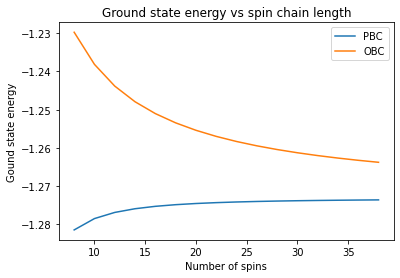

In [7]:
l=np.arange(8, 40, 2)

energiesPBC=[energy(c, 1, periodic=True) for c in l]
energiesOBC=[energy(c, 1, periodic=False) for c in l]

plt.plot(l, energiesPBC, label='PBC')
plt.plot(l, energiesOBC, label='OBC')
plt.legend()
plt.title('Ground state energy vs spin chain length')
plt.xlabel('Number of spins')
plt.ylabel('Gound state energy')
plt.show()

#### Monte Carlo sampling (Ising model)
The Monte Carlo sampling for the transverse quantum Ising chain is performed following a Gibbs sampling fashion: the proposed state $\mathcal{S}'$ is thrown by the flip $\sigma^z_i \rightarrow - \sigma^z_i$ of a single random spin in the chain, and the new state is then accepted with the following probability:

$$\min\biggl(1, \frac{|\psi(\mathcal{S}'; W_k)|^2}{|\psi(\mathcal{S}; W_k)|^2}\biggr)$$
    
It is worth noticing that the power of Monte Carlo sampling lays in the the fact that the acceptance probability is independent of the normalization term of the wavefunciton. This allows to save computational time.
    
In order to make the sampling computationally ligther, we implement the so-called look-up tables for the effective angles, that will be updated once that the $s$ flipped spin sequence $\mathcal S'$ is accepted: 
$\theta_j(S')=\theta_j(S)-2 W_{kj}\sigma^z_s$. [1](#reference_cell)

In [ ]:
# Metropolis and sampler functions:
def WFRatio(A, W, THs, state, prop_state, prob=False):
    '''
    -> Computation of the amplitude ratio between the neural quantum state of the proposed sequence and the current sequence
    
    IN
    A, W           = parameters of the current RBM
    THs            = thetas calculated with the parameters of the current RBM
    state          = current sequence of spins
    prop_state     = proposed sequence of spins from Monte Carlo. simulation
    prob           = boolean value indicating a probability (True) or a complex amplitude (False) as output
            
    OUT
    Amplitude_Ratio = a complex number representing the ratio of the two wavefunctions
    '''    

    delta_s = np.array(prop_state - state, dtype=float).reshape(-1, 1)
    log_ratio = np.dot(A.T, delta_s)-np.sum(np.log(2*np.cosh(THs)))+np.sum(np.log(2*np.cosh(THs+np.dot(W.T, delta_s))))
    Amplitude_Ratio = np.exp(log_ratio)
    
    if prob: return min(1,np.square(np.abs(Amplitude_Ratio)))
    else: return Amplitude_Ratio
    
def Metropolis(state, N_sweeps, N_flips, A, B, W, H_x, B_in, PBC):
    '''
    -> Metropolis sampling on the modulus square of the wavefunction of the current spin sequence

    IN 
    state = current sequence of spins
    N_sweeps      = number of sequences sampled
    N_flips       = number of spin flips per sweep
    A,B,W         = parameters of the current RBM
    H_x           = external field
    B_in          = burn in factor
    PBC           = periodic boundary conditions (Bool)

    OUT (N_sweeps quantities corresponding to one Metropolis run)
    state_history          = sampled sequences
    energy_history         = local energies for each sequence
    np.mean(accept_prob)   = average of the acceptance probability 
    '''
    
    #empty vector
    state_history = []    
    energy_history = []
    average_hamiltonian =[]
    accept_prob = []

    look_up_theta = Theta(B,W,state)                                         
    
    for i in range(int(N_sweeps)):

        for _ in range(int(len(state))):
            
            #Metropolis sampling
            proposed_state = SpinSequenceFlips(state, N_flips)  
            Accept = WFRatio(A, W, look_up_theta, state, proposed_state, prob=True)
            accept_prob.append(float(Accept))

            if np.random.random() < Accept:
                UpdateLookupThetas(look_up_theta, W, state, proposed_state)
                state = proposed_state                            

        en = LocalEnergy(A, W, state, H_x, look_up_theta, PBC)

        #append results to the lists
        state_history.append(state)
        energy_history.append(en)
        average_hamiltonian.append(Hamiltonian(state, PBC))
        
    return state_history[int(B_in*len(state_history)):], \
            energy_history[int(B_in*len(energy_history)):], \
            np.mean(energy_history[int(B_in*len(energy_history)):]), \
            np.mean(accept_prob)

### Stochastic optimization

In order to follow the variational approach for the ground state $\Psi_G$ computation, in which the expectation value $E=E(W)$ of the Hamiltonian $\mathcal H$ is a functional of the RBM parameters $W$, we need to find $W^*$ that solves 

$$\nabla E(W^*)=0$$

The approach we choose is the one proposed in [6](#reference_cell), that adopts a Stochastic Reconfiguation technique to perform the requested minimization.

The weights update at the $p_{th}$ iteration is performed as follows:

$$W(p+1)=W(p)-\eta S^{-1}(p)F(p)$$

We now specify how $S(p), F(p)$ matrices are computed:

$$S_{kk'}=\bigl\langle\mathcal O^*_k \mathcal O_{k'}\bigr\rangle-\bigl\langle\mathcal 
O^*_k\bigr\rangle\bigl\langle\mathcal O_{k'}\bigr\rangle$$

in which we are averaging the variational derivative with respect to the $k_{th}$ network weight

$$\mathcal O_k(\mathcal S)=\frac{1}{\Psi(\mathcal S)}\partial_{W_k}\Psi(\mathcal S)$$

over the samples of the Monte Carlo chain obtained at the $p_{th}$ iteration.

Moreover, we define the so-called forces

$$F_k(p)=\bigl\langle E_{loc} \mathcal O^*_k\bigr\rangle-\bigl\langle E_{loc}\bigr\rangle\bigl\langle\mathcal O^*_k\bigr\rangle$$

with the local energy being the following quantity

$$E_{loc}(\mathcal S)=\frac{\bigl\langle \mathcal S |\mathcal H |\Psi \bigl\rangle}{\Psi(\mathcal S)}$$


It is possible to retrieve the formula of the variational derivatives $\mathcal O$ recalling the wave-form expression as a function of the weights $\psi(\mathcal S, W)$, in which we exploit the definition of the effective angles $\theta_j=b_j+\sum_i W_{ij}\sigma^z_i$:

$$\Psi(\mathcal S)=\exp\bigl(\sum_i a_i\sigma_i \times \prod_{j=1}^M 2\cosh[\theta_j(\mathcal S)] \bigr)$$

from which it holds 
$$\frac{1}{\Psi(\mathcal S)}\partial_{a_i}\Psi(\mathcal S)=\sigma^z_i$$
$$\frac{1}{\Psi(\mathcal S)}\partial_{b_j}\Psi(\mathcal S)=\tanh\bigl[\theta_j(\mathcal S)\bigr]$$
$$\frac{1}{\Psi(\mathcal S)}\partial_{W_{ij}}\Psi(\mathcal S)=\sigma^z_i\tanh\bigl[\theta_j(\mathcal S)\bigr]$$

Since the $S$ matrix may happen to be singular, we  regularize by adding a diagonal matrix 

$$S_{kk'}=S_{kk'}+\lambda(p)\delta_{kk'}S_{kk'}$$ 

$\lambda(p)=\max(\lambda_0 b^p, \lambda_{min})$
and calculate its inverse as the Moore-Penrose pseudo-inverse [1](#reference_cell). 
The parameters are initiliazied as $\lambda_0=100$, $b=0.9$, $\lambda_{min}=10^{-4}$.




The learning rate $\eta$ is a tuning parameter of our architecture: we investigate its impact on the network performances in a successive section.
valori
eventualmente learning rate adattivo
We initialize the $W$ wector as





In [13]:
def LocalEnergy(A, W, state, H_x, THs, PBC):
    '''
    -> Computes the local energy of the current state
    
    IN
    A, W             = A, W weights of the RBM
    state            = current sequence of spins
    H_X              = external magnetic field
    THs              = lookup tables for theta
    PBC              = periodic boundary conditions (Bool)
    
    OUT
    a complex number representing the variational energy estimation
    '''
    
    proposed_states = [state] + [FlipSpinI(np.copy(state),i) for i in range(len(state))]
    matrix_elements = [Hamiltonian(state, PBC)] + [-H_x]*len(state)
    energy_list = [WFRatio(A, W, THs, state, proposed_states[i]) * mel for (i, mel) in enumerate(matrix_elements)]
    return np.sum(energy_list)

def Optimizer(A, B, W, state_hist, energy_hist, ep, N_v, N_h, l_rate):
    '''
    -> Computation of the new parameters of the RBM

    IN            
    A,B,W         = parameters of the current RBM
    state_hist    = all the states from the sampling
    energy_hist   = all the energies of the states
    ep            = current epoch
    N_v           = number of nodes in the visible layer
    N_h           = number of nodes in the hidden layer

    OUT 
    new_a, new_b, new_w = weights for a new RBM

    '''
    
    #local variables initialization
    N_S = len(state_hist)
    sigmas = np.asarray(state_hist).reshape(-1, N_v)
    elocs = np.asarray(energy_hist).reshape(-1, 1)
    partial_Theta = partial(Theta, B, W)
    thetas = np.apply_along_axis(partial_Theta, 1, state_hist).reshape(-1, N_h)
    
    #psi derivatives wrt weights 
    oa = sigmas
    ob = np.tanh(thetas)
    ow = np.einsum('ij,ik->ijk', oa, ob).reshape(-1, N_v*N_h)
    
    #S, P matrices of stochastic reconfiguration
    derivs = np.hstack([oa, ob, ow])
    avg_derivs = np.mean(derivs, axis=0, keepdims=True)
    avg_derivs_mat = np.outer(np.conj(avg_derivs), avg_derivs)
    moment2 = np.einsum('ij,ik->jk', np.conjugate(derivs), derivs)/N_S
    Skk = np.subtract(moment2, avg_derivs_mat)
    Skk += np.diag(np.diag(Skk)*Lambda(ep))
    F_p = np.mean(elocs*np.conjugate(derivs), axis=0)
    F_p -=  np.mean(elocs)*np.mean(np.conjugate(derivs), axis=0) 

    #weights update
    update = np.dot(np.linalg.pinv(Skk),  F_p.reshape(-1,1)).reshape(-1, 1)

    all_weigths = np.concatenate([A.reshape(-1,1), B.reshape(-1,1), W.reshape(-1,1)])
    all_weigths = all_weigths-l_rate*update
    
    new_a = all_weigths[:N_v].reshape(A.shape)
    new_b = all_weigths[N_v:N_v+N_h].reshape(B.shape)
    new_w = all_weigths[N_v+N_h:].reshape(W.shape)

    return new_a, new_b, new_w

def Lambda(p, lambd0=100, b=0.9, lambdMin=1e-4):
        '''
        
        -> Lambda regularization parameter for S_kk matrix,
        see supplementary materials
        '''
        
        return max(lambd0*(b** p), lambdMin)

# Main

In [ ]:
#variables initialization:
np.random.seed(2021857)

n_spins = 8
n_hidden = 32
encoding = [-1,1]

h_x = 1
periodic = True
demagnet = True

init_weight = 0.001

n_sweeps = 10000

n_flips = 1

N_epochs = 500
learning_rate = 0.01
burn_in = 0.01

#iterative part
a,b,w = InitializeRBM(n_spins, n_hidden, init_weight)
current_state = NewSpinSequence(n_spins, encoding, demagnet)

avgElocs_vector = []
accept_vector = []

for epoch in range(N_epochs):

    state_history, energy_history, avg_Elocs, accept_prob = Metropolis(current_state, 
                                                                                        n_sweeps,
                                                                                        n_flips,
                                                                                        a, b, w,
                                                                                        h_x,
                                                                                        burn_in,
                                                                                        periodic)
    current_state = state_history[-1]
    avgElocs_vector.append(avg_Elocs)
    print('EPOCH: ', epoch, ' AvgElocs: ', avg_Elocs.real/n_spins)
    accept_vector.append(accept_prob)
    a,b,w = Optimizer(a, b, w, state_history, energy_history, epoch, n_spins, n_hidden, learning_rate)

## Why don't we use Hamiltonian expectation value?

In [14]:
def WFProb(A, B, W, state): 
    log_psi = np.dot(A.T, state)+np.sum(np.log(2*np.cosh(B+np.dot(W.T, state))))
    print(log_psi.real)
    return log_psi.real, np.square(np.abs(np.exp(log_psi)))

n_spins = 40
encoding = [-1,1]
demagnet = True

current_state = NewSpinSequence(n_spins, encoding, demagnet)
a,b,w = InitializeRBM(40, 40, 0.001)
print(WFProb(a, b, w, current_state)[1])

[1109.03940353]
[inf]


<ipython-input-14-58f1ecb64dfc>:4: RuntimeWarning: overflow encountered in exp
  return log_psi.real, np.square(np.abs(np.exp(log_psi)))


### Tuning the learning rate

While trying to find the best configurations of hyper-parameters for the architecture, we face the need to set the value of the learning rate. In principle two ideas are possible: a constant learning rate $\bar{\eta}$ or an adaptive learning rate $\eta(p)$, depending on the epoch $p$. As the analysis of the 40 spins chain suggests, a constant learning rate of the order $10^{-2}$ will generally ensure convergence, for sufficiently large systems. On the other hand, if the amount of spins is small (and hence also the number of trainable weights to store informations on the gradiend descent) a too large learning rate can make the weights update unstable, while a too small one can make them change too slowly in time. Indeed, even with just 20 spins we can see how the choice of an adaptive learning rate is the most functional to the analysis:

![20.pdf](20.pdf)

As the plot above suggests, there is still margin for improvement in order to reach the theoretical minimum of the energy. However, this could be achieved by a fine tuning of the three parameters $\eta_0,d,r$ of the adaptive learning rate proposed:

$$
\eta(p) = \eta_0 \cdot d^{(1+p)r}
$$

In details, for the plot above the choice has been $\eta_0 = 0.1$, $d = 0.87$, $r=0.5$, which allows the variational energy to move below the local minimum in which are stucked the simulations with fixed learning rates.

## Results


In [38]:
def RealPart(df):
    
    '''
    -> converts a dataframe of complex value tu a dataframe with only real part
    '''
    
    df=df.to_numpy()
    for i in range(len(df)):
        df[i]=np.real(complex(df[i]))
    return df

### $N=8$

Hyperparameters for results reproducibility
* $\alpha=1$;
* Encoding $[-1,1]$;
* $h_x=1$;
* Open boundary conditions;
* Init weight $=0.001$;

* $n_{epochs}=1000$;

* $n_{sweeps}=1000$;
* $n_{flips}=1$;
* Burn in $= 0.01$;

In [9]:
N=8
epochs=1000
DMRG_8 = energy(8, 1, periodic=False)

lr001  = RealPart(pd.read_csv('Energies/Elocs_8_lr0.01.csv'))
lr0001 = RealPart(pd.read_csv('Energies/Elocs_8_lr0.001.csv'))
lradap = RealPart(pd.read_csv('Energies/Elocs_8_lrada.csv'))

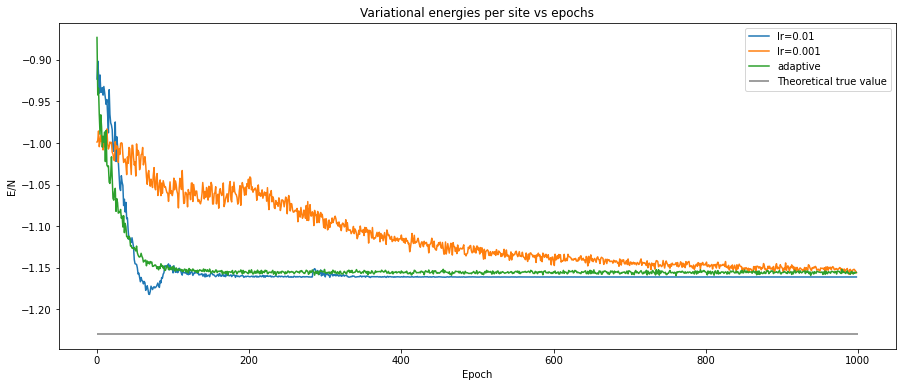

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(lr001, label='lr=0.01')
plt.plot(lr0001, label='lr=0.001')
plt.plot(lradap, label='adaptive')
plt.hlines(y=DMRG_8, xmin=0, xmax=epochs, color='grey', label='Theoretical true value')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('E/N')
plt.title('Variational energies per site vs epochs')
plt.show()

### $N=16$

Hyperparameters for results reproducibility
* $\alpha=1$;
* Encoding $[-1,1]$;
* $h_x=1$;
* Open boundary conditions;
* Init weight $=0.001$;

* $n_{epochs}=1000$;

* $n_{sweeps}=1000$;
* $n_{flips}=1$;
* Burn in $= 0.01$;

In [35]:
N=16
epochs=1000
DMRG_16 = energy(16, 1, periodic=False)


lr001  = RealPart(pd.read_csv('Energies/Elocs_16_lr0.01.csv'))
lr0001 = RealPart(pd.read_csv('Energies/Elocs_16_lr0.001.csv'))
lradap = RealPart(pd.read_csv('Energies/Elocs_16_lrada.csv'))

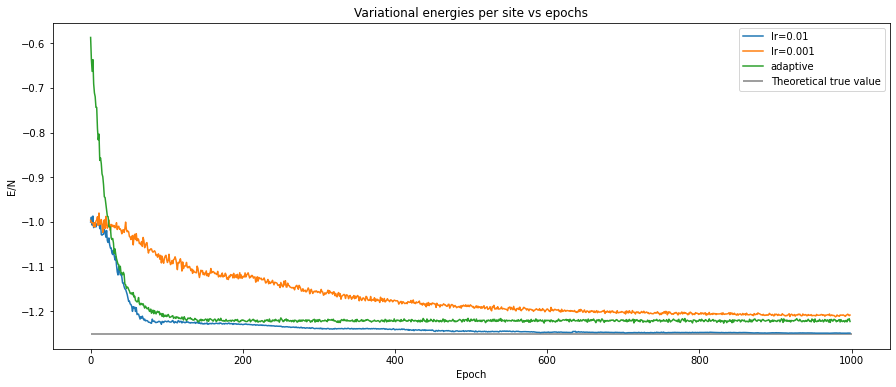

In [36]:
plt.figure(figsize=(15, 6))

#plt.plot(lr01, label='lr=0.1')
plt.plot(lr001, label='lr=0.01')
plt.plot(lr0001, label='lr=0.001')
plt.plot(lradap, label='adaptive')

plt.hlines(y=DMRG_16, xmin=0, xmax=epochs, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N')
plt.title('Variational energies per site vs epochs')

plt.legend()
plt.show()

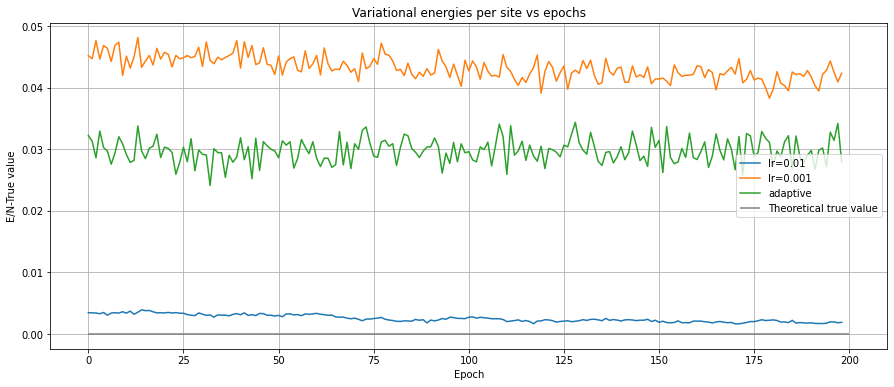

In [37]:
plt.figure(figsize=(15, 6))

plt.plot(lr001[800:]-DMRG_16, label='lr=0.01')
plt.plot(lr0001[800:]-DMRG_16, label='lr=0.001')
plt.plot(lradap[800:]-DMRG_16, label='adaptive')

plt.hlines(y=0, xmin=0, xmax=200, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N-True value')
plt.title('Variational energies per site vs epochs')
plt.grid()
plt.legend()
plt.show()

### $N=20$

Hyperparameters for results reproducibility
* $\alpha=1$;
* Encoding $[-1,1]$;
* $h_x=1$;
* Open boundary conditions;
* Init weight $=0.001$;

* $n_{epochs}=400$;

* $n_{sweeps}=500$;
* $n_{flips}=1$;
* Burn in $= 0.1$;

In [27]:
N=20
epochs=400
DMRG_20 = energy(20, 1, periodic=False)

lr001  = RealPart(pd.read_csv('Energies/Elocs_20_lr0.01.csv'))/N
lr0001 = RealPart(pd.read_csv('Energies/Elocs_20_lr0.001.csv'))/N
lradap = RealPart(pd.read_csv('Energies/Elocs_20_lrada.csv'))/N

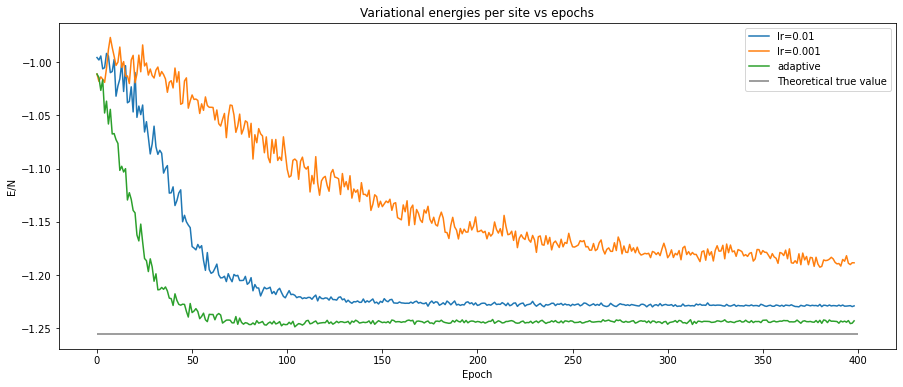

In [28]:
plt.figure(figsize=(15, 6))

plt.plot(lr001, label='lr=0.01')
plt.plot(lr0001, label='lr=0.001')
plt.plot(lradap, label='adaptive')

plt.hlines(y=DMRG_20, xmin=0, xmax=epochs, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N')
plt.title('Variational energies per site vs epochs')

plt.legend()
plt.show()

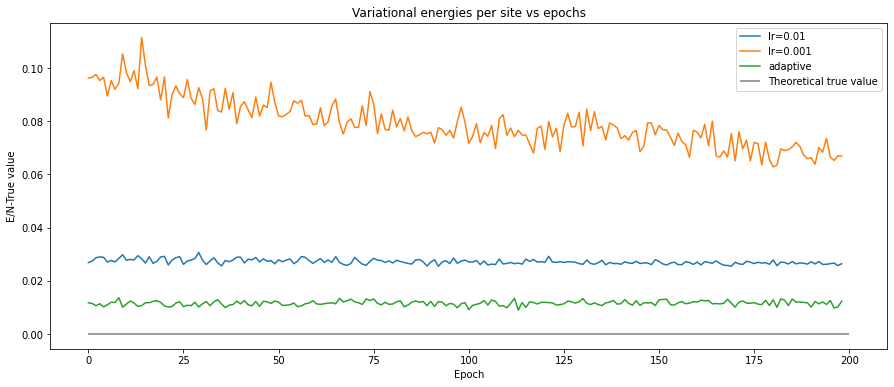

In [30]:
plt.figure(figsize=(15, 6))

plt.plot(lr001[200:]-DMRG_20, label='lr=0.01')
plt.plot(lr0001[200:]-DMRG_20, label='lr=0.001')
plt.plot(lradap[200:]-DMRG_20, label='adaptive')

plt.hlines(y=0, xmin=0, xmax=200, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N-True value')
plt.title('Variational energies per site vs epochs')

plt.legend()
plt.show()

### $N=40$

Hyperparameters for results reproducibility
* $\alpha=1$;
* Encoding $[-1,1]$;
* $h_x=1$;
* Open boundary conditions;
* Init weight $=0.001$;

* $n_{epochs}=400$;

* $n_{sweeps}=1000$;
* $n_{flips}=1$;
* Burn in $= 0.1$;

In [40]:
N=40
epochs=400
DMRG_40 = energy(40, 1, periodic=False)

lr001  = RealPart(pd.read_csv('Energies/Elocs_40_lr0.01.csv'))/N
lr0001 = RealPart(pd.read_csv('Energies/Elocs_40_lr0.001.csv'))/N
lradap = RealPart(pd.read_csv('Energies/Elocs_40_lrada.csv'))/N

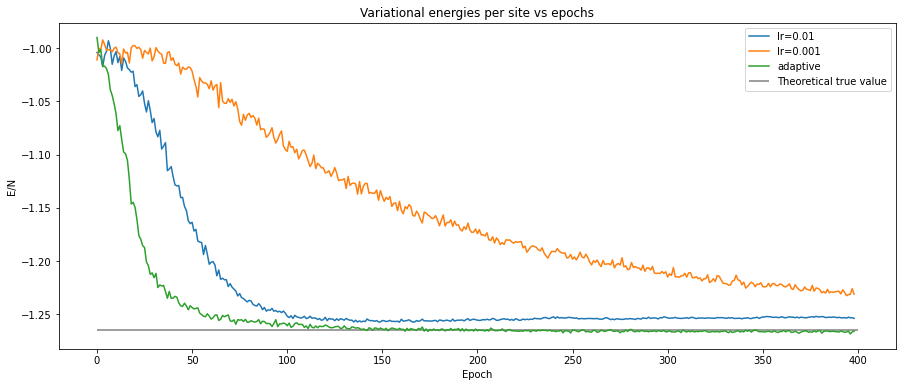

In [41]:
plt.figure(figsize=(15, 6))

plt.plot(lr001, label='lr=0.01')
plt.plot(lr0001, label='lr=0.001')
plt.plot(lradap, label='adaptive')

plt.hlines(y=DMRG_40, xmin=0, xmax=epochs, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N')
plt.title('Variational energies per site vs epochs')

plt.legend()
plt.show()

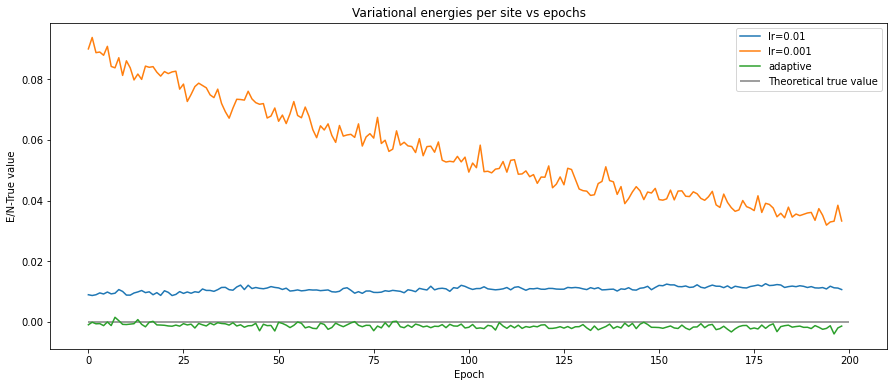

In [42]:
plt.figure(figsize=(15, 6))

plt.plot(lr001[200:]-DMRG_40, label='lr=0.01')
plt.plot(lr0001[200:]-DMRG_40, label='lr=0.001')
plt.plot(lradap[200:]-DMRG_40, label='adaptive')

plt.hlines(y=0, xmin=0, xmax=200, color='grey', label='Theoretical true value')
plt.xlabel('Epoch')
plt.ylabel('E/N-True value')
plt.title('Variational energies per site vs epochs')

plt.legend()
plt.show()

# Conclusions

We have been able to reproduce the ground state energy for the Transverse Field Ising Model for different spin chain lengths. We really appreciated working together on something that joins the Restricted Boltzmann Machines (ML architectures arising from Statistical Mechanics) and the Many-Body Quantum Physics. 

## Outlooks and side work